### Fix Data

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
#importing the data 
df_actual = pd.read_csv('UTMSBA_ACTL.csv')
#df_schd = pd.read_csv('UTMSBA_SCHD.csv')
df1 = df_actual.copy()
#df2 = df_schd.copy()

In [4]:
#Added cols
df1['pairs'] = df1['Orig'] + ' - ' + df1['Dest']

In [5]:
#Dates
def date_format(value):
    value = str(value)
    year = int(value[:4])
    month = int(value[5:7])
    day = int(value[8:])
    
    #print(year,month,day)
    date = datetime.date(year,month, day)
    return date 

df1['Dep_dt'] = df1['Dep_dt'].map(date_format)
df1['day_of_week'] = df1['Dep_dt'].apply(lambda x: dt.weekday(x))

#year_month
def year_month(value):
    value = str(value)
    return str(value[:7])

df1['year_month'] = df1['Dep_dt'].map(year_month)

In [6]:
#Arrival time
def hour_of_the_day(time):
    time = str(time)
    return int(time[:-2])

df1['hour_out'] = df1['ACTL_TM_OUT_CENT'].map(hour_of_the_day)
df1['hour_in'] = df1['ACTL_TM_IN_CENT'].map(hour_of_the_day)

In [7]:
#Pull out month
def pull_month(value):
    value = str(value)
    month = int(value[5:7])
    return month

df1['month'] = df1['Dep_dt'].map(pull_month)

In [36]:
#Pull out year
def pull_year(value):
    value = str(value)
    year = int(value[:4])
    return year

df1['year'] = df1['Dep_dt'].map(pull_year)

In [8]:
#Name day of week
import calendar
days = list(calendar.day_abbr)
def name_day(value): 
    return days[value]

df1['day'] = df1['day_of_week'].map(name_day)

In [34]:
#create weeks
df1['Dep_dt'][0].strftime('%W') #first week = 35th week of the year
df1['week_of_year'] = df1['Dep_dt'].apply(lambda x: x.strftime('%W'))

In [37]:
df1.head()

,Dep_dt,Orig,Dest,Tail,Stage_length,ACTL_TM_IN_CENT,ACTL_TM_OUT_CENT,ACFT,Actl_BM,Gross_gal,...,Tanker_gal,pairs,day_of_week,year_month,hour_out,hour_in,month,day,week_of_year,year
0,2017-09-01,FYX,ZEY,N09303,240,1005,844,73W,81,536.3,...,0.0,FYX - ZEY,4,2017-09,8,10,9,Fri,35,2017
1,2017-09-01,ZEY,KMU,N09303,274,1139,1043,73W,56,1145.6,...,0.0,ZEY - KMU,4,2017-09,10,11,9,Fri,35,2017
2,2017-09-01,KMU,DWF,N09303,1419,1520,1221,73W,179,1923.3,...,0.0,KMU - DWF,4,2017-09,12,15,9,Fri,35,2017
3,2017-09-01,DWF,ZEY,N09303,1213,1838,1556,73W,162,2115.7,...,0.0,DWF - ZEY,4,2017-09,15,18,9,Fri,35,2017
4,2017-09-01,ZEY,FSG,N09303,1051,2140,1925,73W,135,2703.5,...,1029.7,ZEY - FSG,4,2017-09,19,21,9,Fri,35,2017


### ARIMA

In [12]:
# #Check trends across day and month
# sample = df1.sample(10000)
# px.box(sample, x="day", y="Gross_gal")
# px.box(sample, x="month", y="Gross_gal")
# #similar plots across both

In [13]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [53]:
#use single year of data for single origin
origin_set = df1[df1['Orig'] =='FYX']
og_set = origin_set[origin_set['year'] == 2018]
origin_gals = og_set.groupby(['week_of_year'])['Gross_gal'].sum()[:45]

In [54]:
origin_gals

week_of_year
01    313386.4
02    288370.5
03    289873.8
04    308820.1
05    273954.6
06    235927.9
07    279661.2
08    298136.4
09    277385.1
10    270161.6
11    286451.0
12    292418.5
13    254404.6
14    274639.6
15    294899.7
16    290224.4
17    289348.7
18    286405.7
19    274774.5
20    345339.1
21    317114.4
22    254460.3
23    318749.5
24    328381.3
25    323185.4
26    377715.5
27    373574.4
28    463680.6
29    440860.2
30    441727.9
31    478111.7
32    396485.4
33    389531.0
34    359607.6
35    355075.0
36    337571.1
37    319104.8
38    328465.5
39    301948.1
40    375916.9
41    332179.4
42    294522.0
43    260878.9
44    267300.5
45    289832.7
Name: Gross_gal, dtype: float64

In [55]:
#AD Fuller test to check if data stationary (if p > .05 then not stationary and need to difference)
result = adfuller(origin_gals.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.093428377568069
p-value: 0.24716528155319556


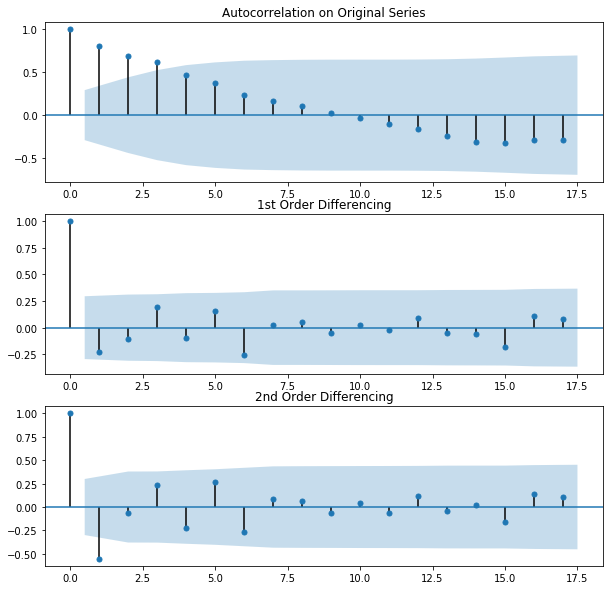

In [56]:
#plot autocorr. to see how to difference
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(origin_gals, ax=ax1, title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(origin_gals.diff().dropna(), ax=ax2, title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(origin_gals.diff().diff().dropna(), ax=ax3, title="2nd Order Differencing")

In [46]:
# #Choose p and q (# of points > sig. level)
# lag = 50
# #p using partial autocorr.
# plot_pacf(origin_gals.diff().dropna(), lags=lag)
# plt.show()

# #q using autocorr.
# plot_acf(origin_gals.diff().dropna())
# plt.show()

In [57]:
#Model
model = ARIMA(origin_gals, order=(1, 1, 1))
results = model.fit()
results.summary()

C:\Users\lasha\Anaconda2\envs\Python 3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\lasha\Anaconda2\envs\Python 3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Gross_gal   No. Observations:                   44
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -521.963
Method:                       css-mle   S.D. of innovations          34303.468
Date:                Sun, 23 Feb 2020   AIC                           1051.926
Time:                        20:19:37   BIC                           1059.063
Sample:                             1   HQIC                          1054.573
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -513.7873   3782.607     -0.136      0.893   -7927.561    6899.986
ar.L1.D.Gross_gal     0.0304      0.407      0.075      0.941      -0.768       0.829
ma.L1.D.Gross_gal    -0.2972      0.375     -0.793      0.433      -1.032       0.438
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           32.9428           +0.0000j           32.9428            0.0000
MA.1            3.3650           +0.0000j            3.3650            0.0000
-----------------------------------------------------------------------------
"""

C:\Users\lasha\Anaconda2\envs\Python 3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\lasha\Anaconda2\envs\Python 3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\lasha\Anaconda2\envs\Python 3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



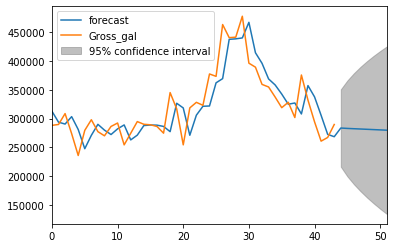

In [62]:
graph = results.plot_predict(1, 52)
plt.show()